<a href="https://colab.research.google.com/github/Ekarpova/Project_Find_My_Dress/blob/main/EKarpova_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
#myfile = open('gdrive/My Drive/test_file.csv')

In [ ]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 189 kB 13.8 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 


In [ ]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastai.vision.all import *
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
def rgb_display(path1, path2):
    image1 = mpimg.imread(path1)
    image2 = mpimg.imread(path2)
    
    plt.axis("off")
    #fig = plt.figure(figsize=(4., 4.))
    fig = plt.figure(figsize=[20, 20])
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )
     
    for ax, im in zip(grid, [image1, image2]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)


    return plt.show()

In [ ]:
class Config():
    
    training_dir = "gdrive/My Drive/MyProject_colab/data/train"
    eval_dir = "gdrive/My Drive/MyProject_colab/data/eval_data"
    anchor_folder = "gdrive/My Drive/MyProject_colab/data/original"
    test_folder = "gdrive/My Drive/MyProject_colab/data/test"
    
    train_batch_size = 64
    train_number_epochs = 100

In [ ]:
Config.training_dir

'gdrive/My Drive/MyProject_colab/data/train'

In [ ]:
files_anchor = get_image_files(Config.anchor_folder)
files_anchor[5]

Path('gdrive/My Drive/MyProject_colab/data/train/gown/gown_4.jpg')

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)),img0_tuple[0],img1_tuple[0]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

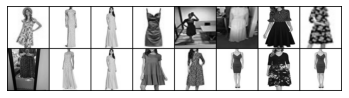

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

DEFINING CONTRASTIVE LOSS

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

TRAINING STARTS **HERE** 

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label,_,_ = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
                show_plot(counter,loss_history)
    return net

Epoch number 0
 Current loss 2.085247278213501



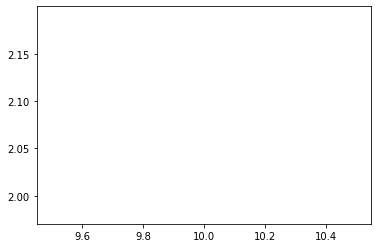

Epoch number 1
 Current loss 29.13141632080078



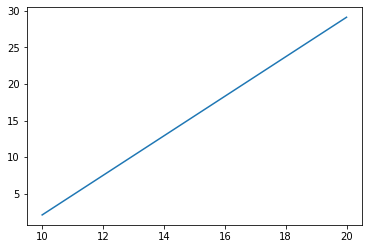

Epoch number 2
 Current loss 29.234270095825195



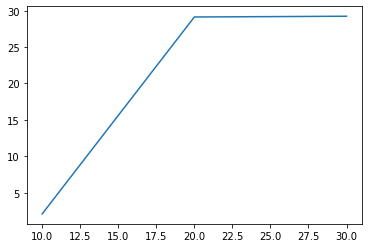

Epoch number 3
 Current loss 28.640430450439453



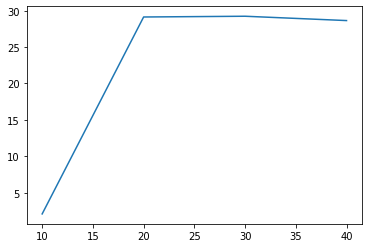

Epoch number 4
 Current loss 14.551852226257324



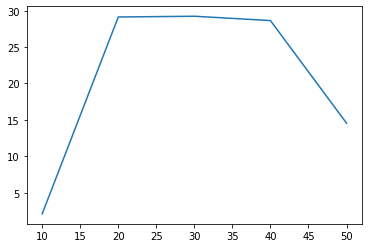

Epoch number 5
 Current loss 17.736909866333008



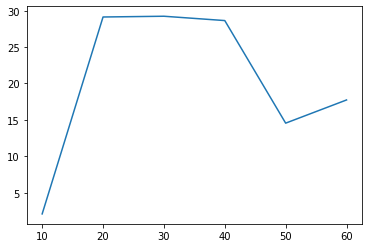

Epoch number 6
 Current loss 8.776763916015625



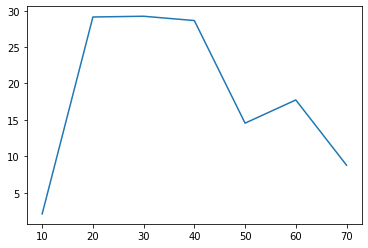

Epoch number 7
 Current loss 4.940433979034424



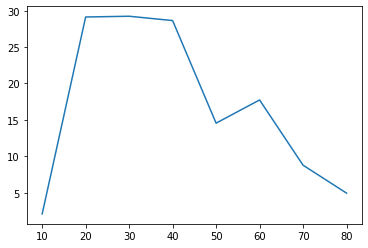

Epoch number 8
 Current loss 6.713796615600586



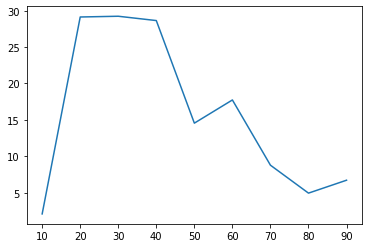

Epoch number 9
 Current loss 7.580349922180176



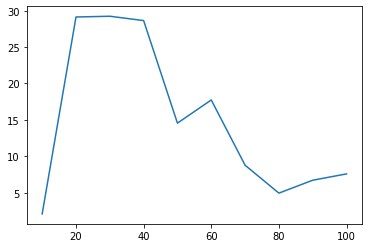

Epoch number 10
 Current loss 4.622297286987305



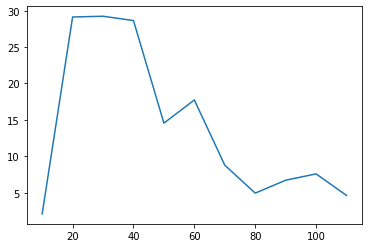

Epoch number 11
 Current loss 9.17878532409668



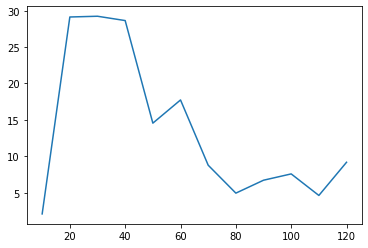

Epoch number 12
 Current loss 4.641905307769775



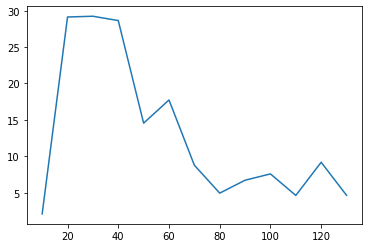

Epoch number 13
 Current loss 6.1954851150512695



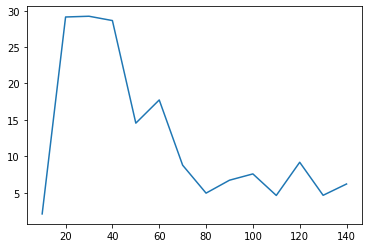

Epoch number 14
 Current loss 4.588801383972168



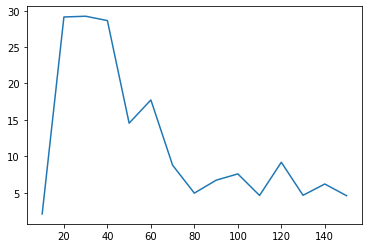

Epoch number 15
 Current loss 4.195110321044922



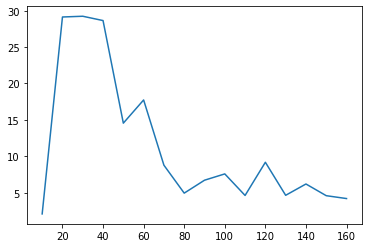

Epoch number 16
 Current loss 3.2835726737976074



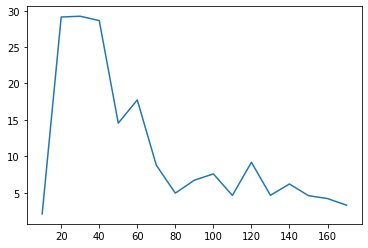

Epoch number 17
 Current loss 5.610687732696533



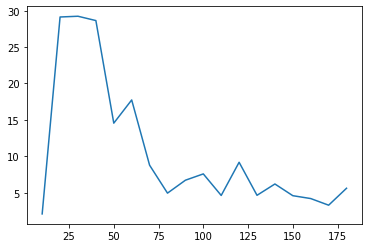

Epoch number 18
 Current loss 5.98341703414917



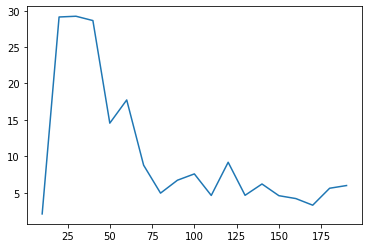

Epoch number 19
 Current loss 2.919968605041504



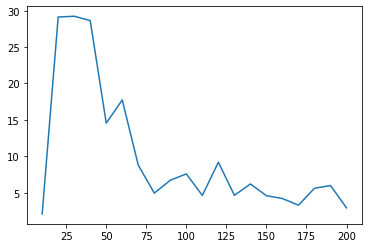

Epoch number 20
 Current loss 3.1126160621643066



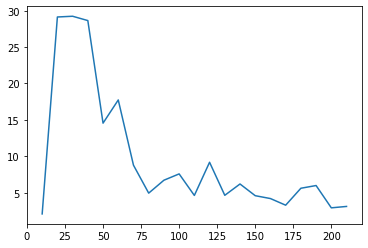

Epoch number 21
 Current loss 3.657985210418701



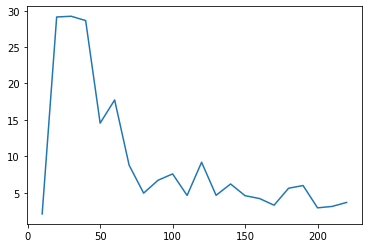

Epoch number 22
 Current loss 2.6932644844055176



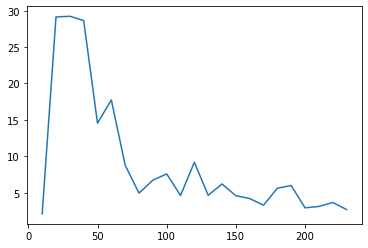

Epoch number 23
 Current loss 3.4845669269561768



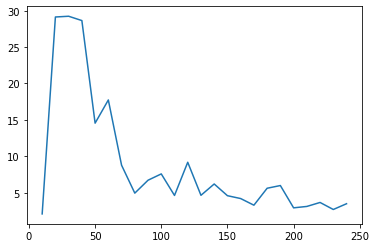

Epoch number 24
 Current loss 3.930617332458496



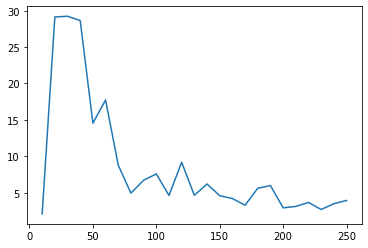

Epoch number 25
 Current loss 3.3974459171295166



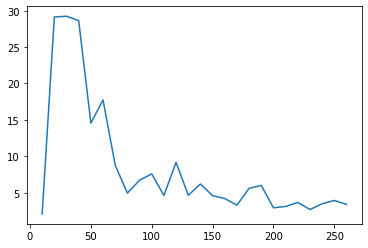

Epoch number 26
 Current loss 4.731760025024414



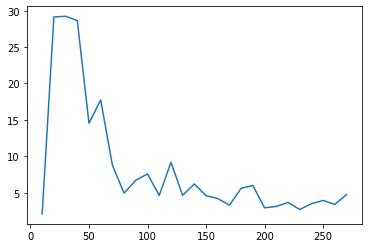

Epoch number 27
 Current loss 5.313736915588379



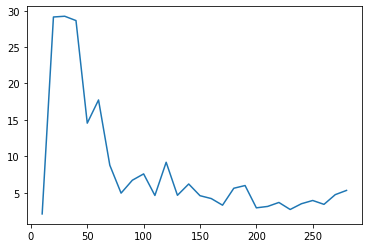

Epoch number 28
 Current loss 3.210339069366455



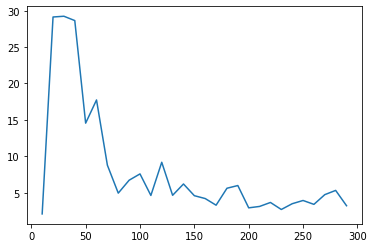

Epoch number 29
 Current loss 2.7012228965759277



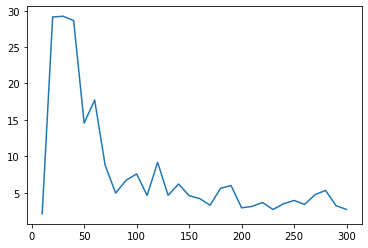

Epoch number 30
 Current loss 2.7035601139068604



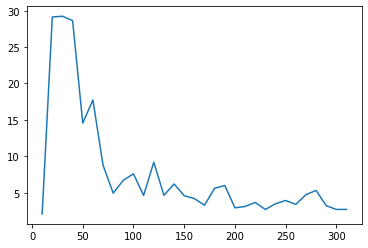

Epoch number 31
 Current loss 1.4479336738586426



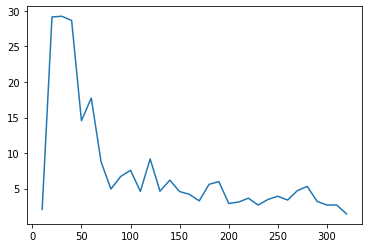

Epoch number 32
 Current loss 4.021934509277344



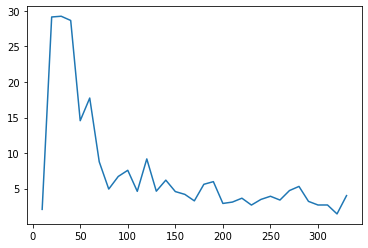

Epoch number 33
 Current loss 6.063902854919434



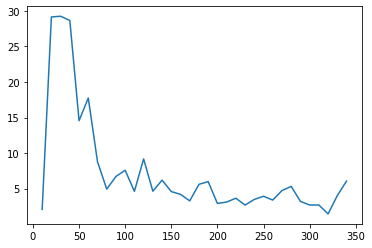

Epoch number 34
 Current loss 1.5566999912261963



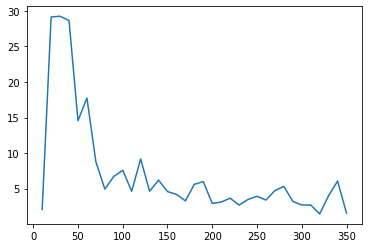

Epoch number 35
 Current loss 5.922541618347168



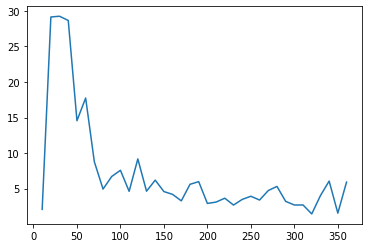

Epoch number 36
 Current loss 3.2613039016723633



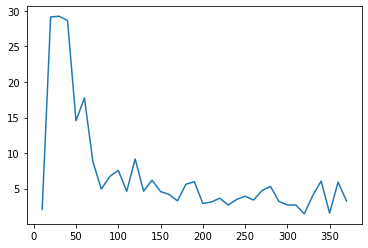

Epoch number 37
 Current loss 3.5610580444335938



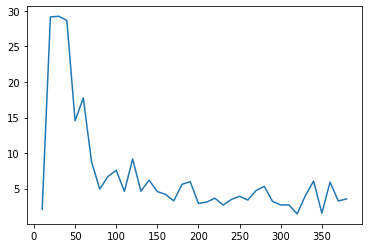

Epoch number 38
 Current loss 1.2110387086868286



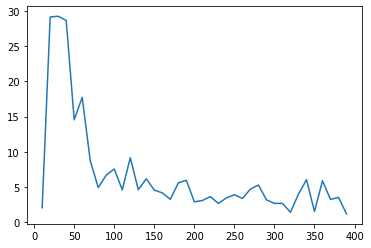

Epoch number 39
 Current loss 2.3716890811920166



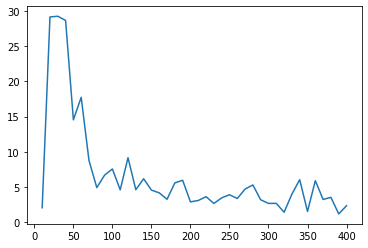

Epoch number 40
 Current loss 2.2588648796081543



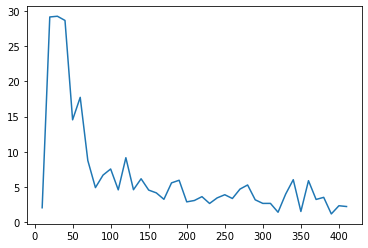

Epoch number 41
 Current loss 1.9271152019500732



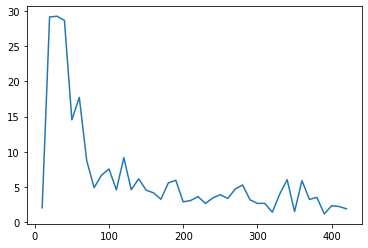

Epoch number 42
 Current loss 2.7339653968811035



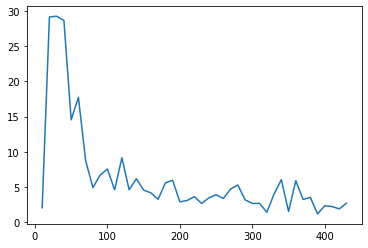

Epoch number 43
 Current loss 1.4998515844345093



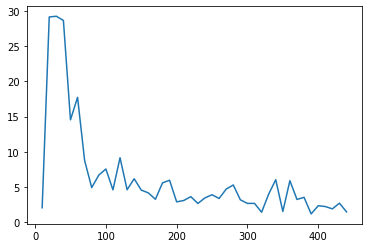

Epoch number 44
 Current loss 7.7112298011779785



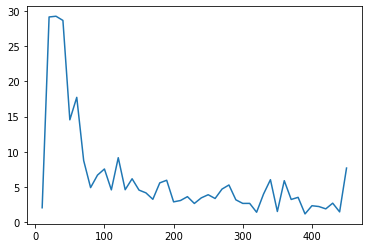

Epoch number 45
 Current loss 2.323424816131592



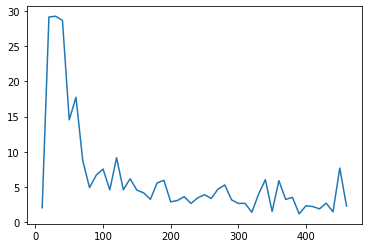

Epoch number 46
 Current loss 3.5862207412719727



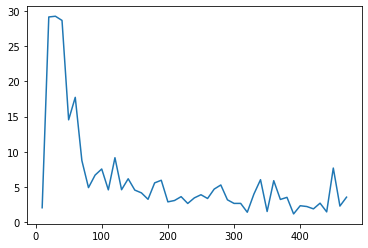

Epoch number 47
 Current loss 0.9253912568092346



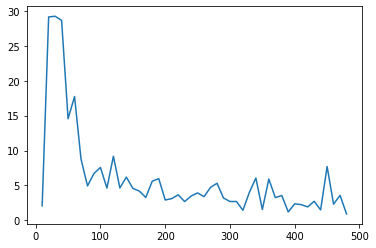

Epoch number 48
 Current loss 1.215376615524292



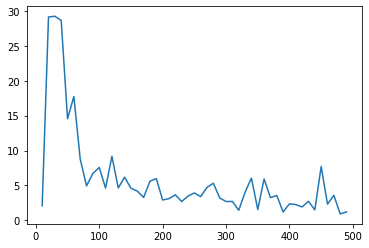

Epoch number 49
 Current loss 1.596909761428833



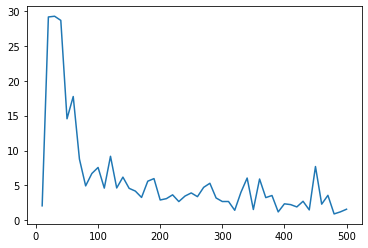

Epoch number 50
 Current loss 3.027461290359497



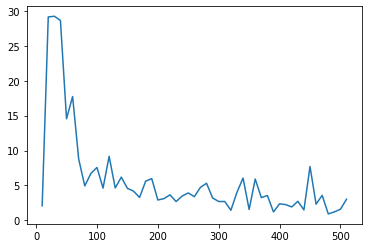

Epoch number 51
 Current loss 1.1573480367660522



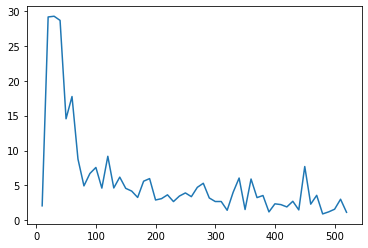

Epoch number 52
 Current loss 1.2477692365646362



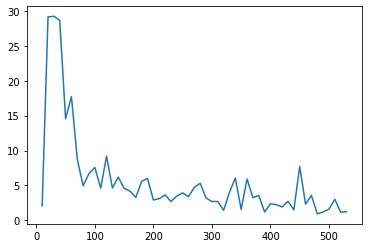

Epoch number 53
 Current loss 0.8225156664848328



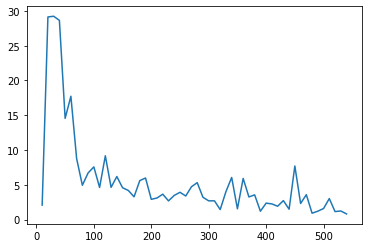

Epoch number 54
 Current loss 1.2414138317108154



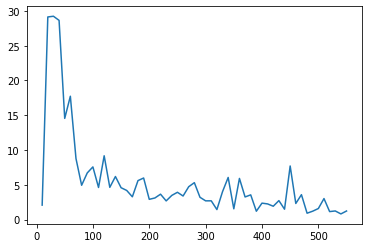

Epoch number 55
 Current loss 0.7964373230934143



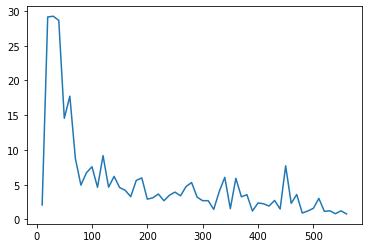

Epoch number 56
 Current loss 2.130014419555664



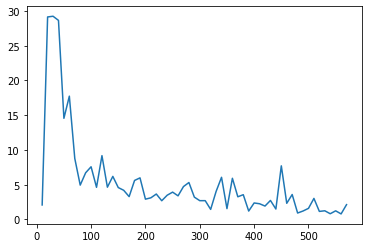

Epoch number 57
 Current loss 1.5407873392105103



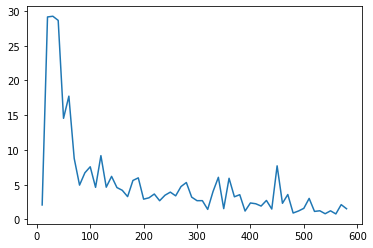

Epoch number 58
 Current loss 1.1052719354629517



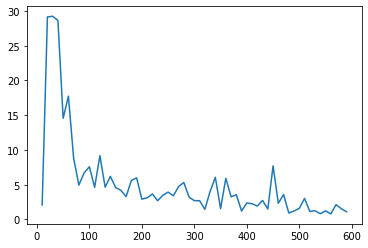

Epoch number 59
 Current loss 1.0367391109466553



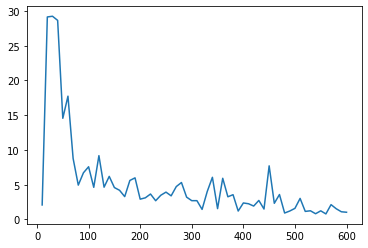

Epoch number 60
 Current loss 1.7113730907440186



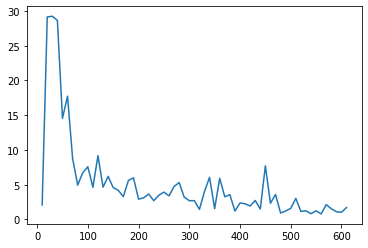

Epoch number 61
 Current loss 0.8523105978965759



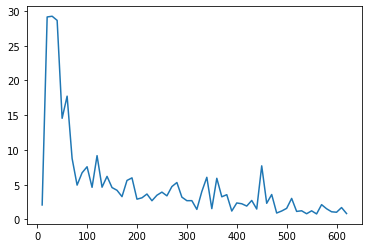

Epoch number 62
 Current loss 0.7901020646095276



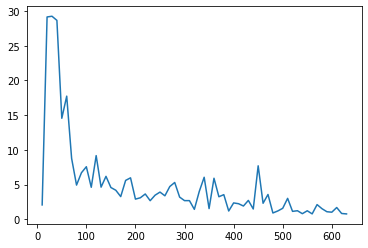

Epoch number 63
 Current loss 1.328352928161621



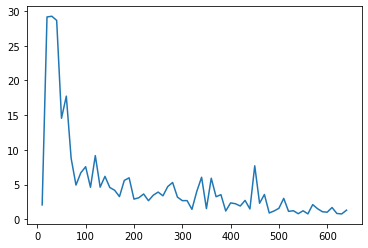

Epoch number 64
 Current loss 0.9417815208435059



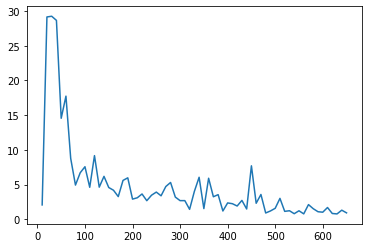

Epoch number 65
 Current loss 1.036110520362854



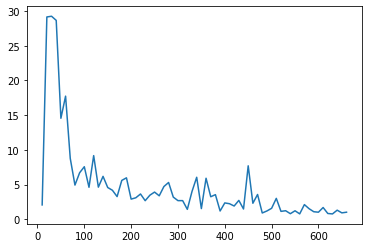

Epoch number 66
 Current loss 0.9058619141578674



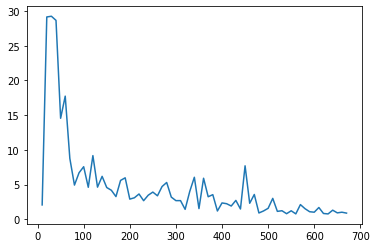

Epoch number 67
 Current loss 0.7145202159881592



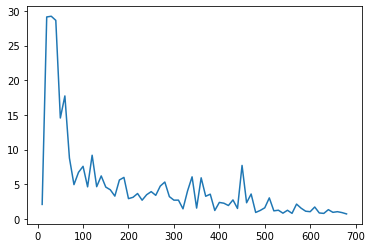

Epoch number 68
 Current loss 0.951150119304657



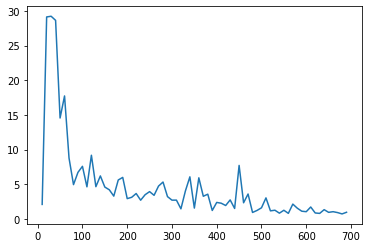

Epoch number 69
 Current loss 0.9814261794090271



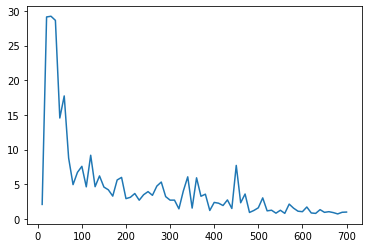

Epoch number 70
 Current loss 0.5636147260665894



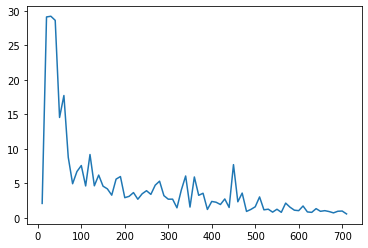

Epoch number 71
 Current loss 0.5113179683685303



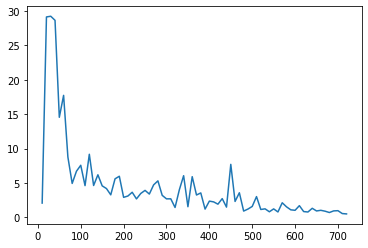

Epoch number 72
 Current loss 0.4838803708553314



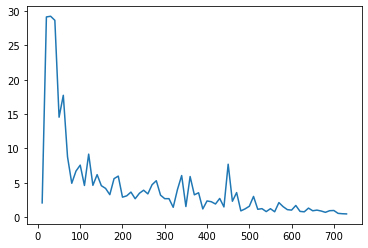

Epoch number 73
 Current loss 1.2024798393249512



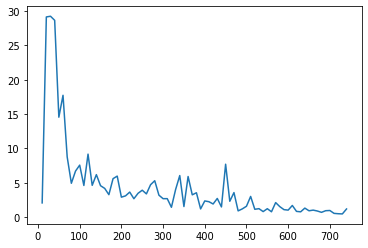

Epoch number 74
 Current loss 0.5077955722808838



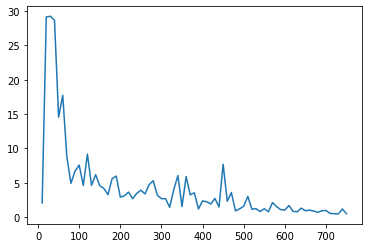

Epoch number 75
 Current loss 0.753121018409729



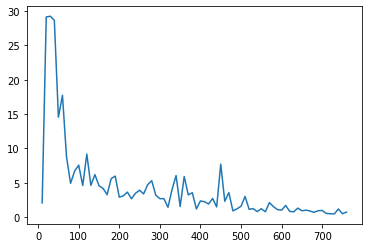

Epoch number 76
 Current loss 0.5069210529327393



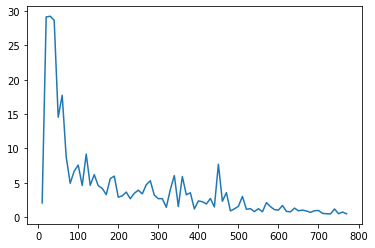

Epoch number 77
 Current loss 0.4949038028717041



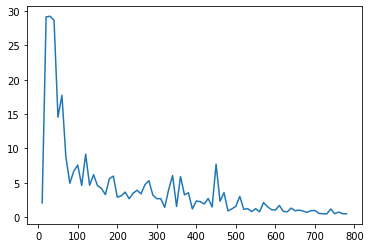

Epoch number 78
 Current loss 0.673254132270813



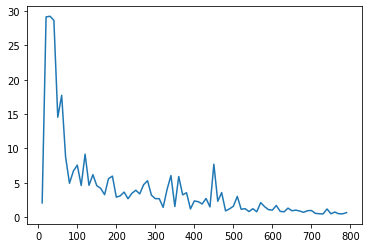

Epoch number 79
 Current loss 0.7812305092811584



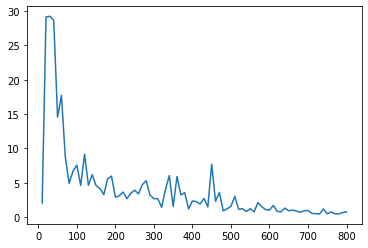

Epoch number 80
 Current loss 0.3175910413265228



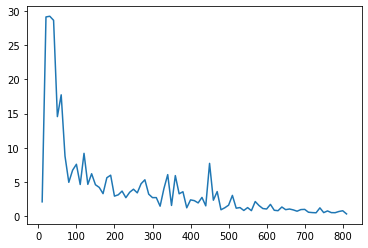

Epoch number 81
 Current loss 0.5111913084983826



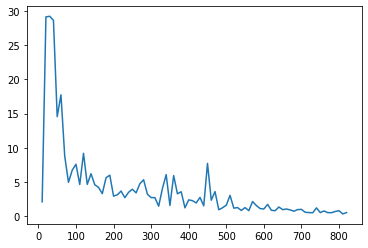

Epoch number 82
 Current loss 0.3092087507247925



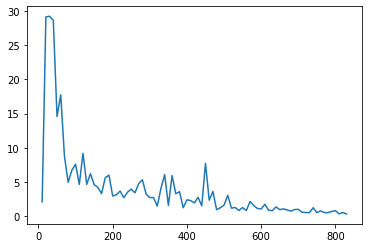

Epoch number 83
 Current loss 0.4371922016143799



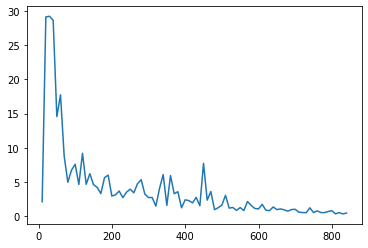

Epoch number 84
 Current loss 0.4240948557853699



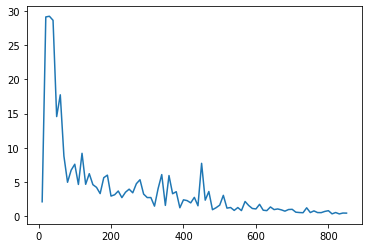

Epoch number 85
 Current loss 0.4279826283454895



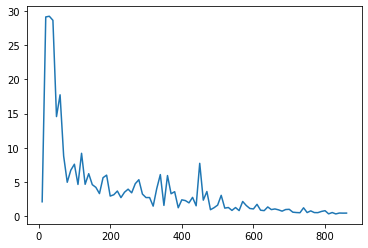

Epoch number 86
 Current loss 0.30379313230514526



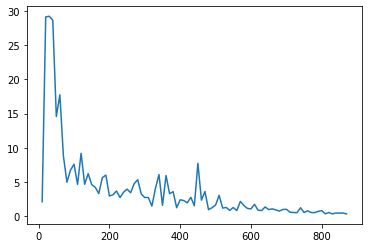

Epoch number 87
 Current loss 0.5488176345825195



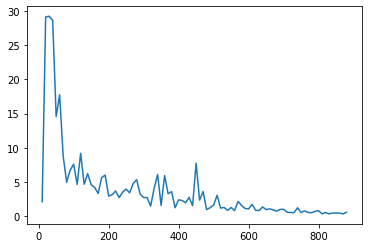

Epoch number 88
 Current loss 0.4619475305080414



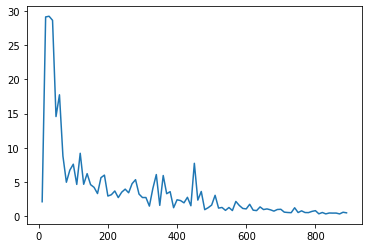

Epoch number 89
 Current loss 0.3984473943710327



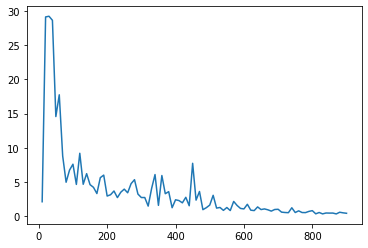

Epoch number 90
 Current loss 0.5677857398986816



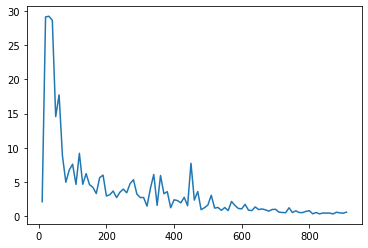

Epoch number 91
 Current loss 0.3271001875400543



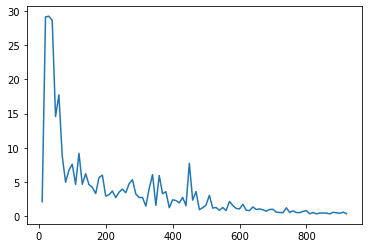

Epoch number 92
 Current loss 0.222757026553154



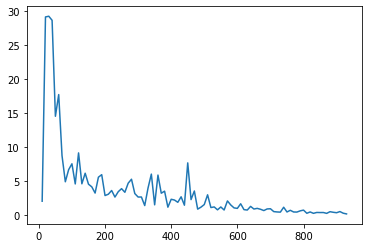

Epoch number 93
 Current loss 0.3161201477050781



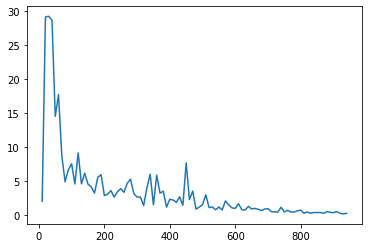

Epoch number 94
 Current loss 0.35082754492759705



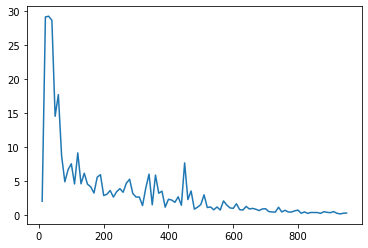

Epoch number 95
 Current loss 0.26753926277160645



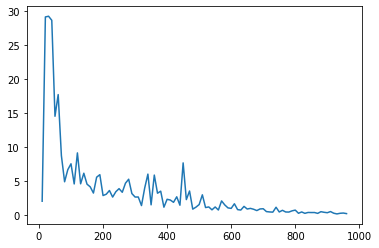

Epoch number 96
 Current loss 0.5395636558532715



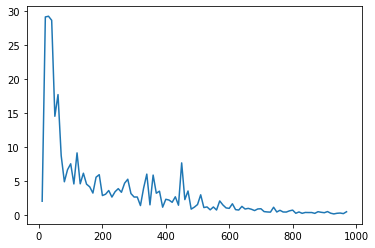

Epoch number 97
 Current loss 0.6305299997329712



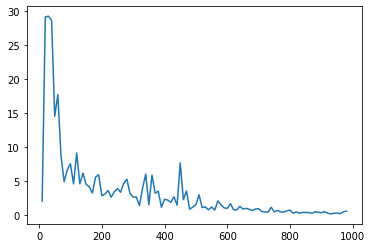

Epoch number 98
 Current loss 0.26673680543899536



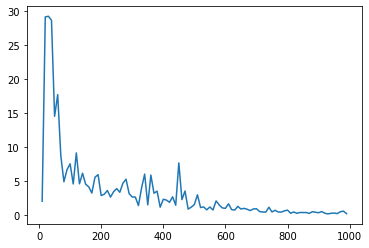

Epoch number 99
 Current loss 0.2513802647590637



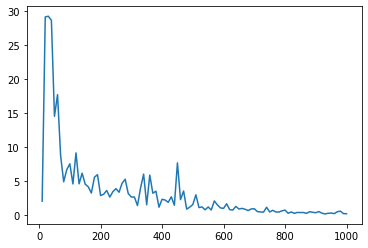

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Training the model
model = train()

In [ ]:
torch.save(model.state_dict(), "gdrive/My Drive/MyProject_colab/data/SiameseNet2.pt")
print("Model Saved Successfully")

Model Saved Successfully


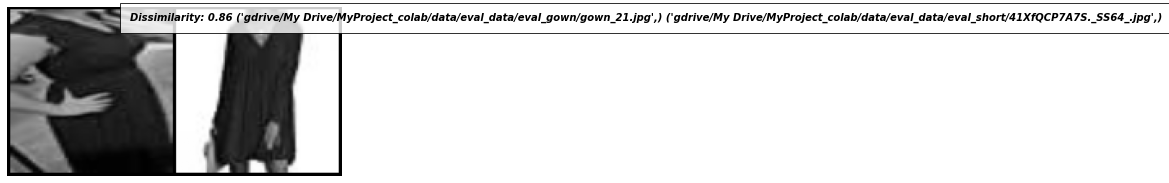

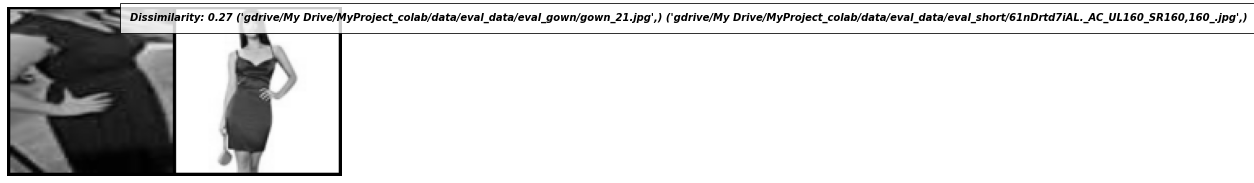

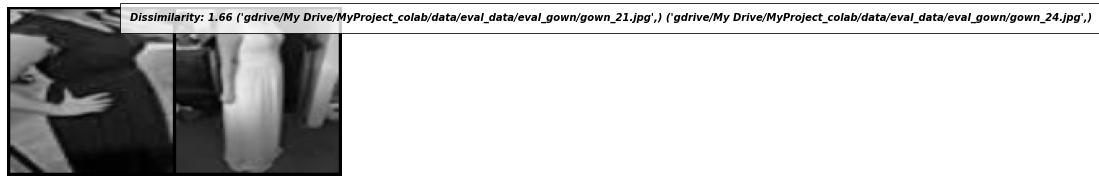

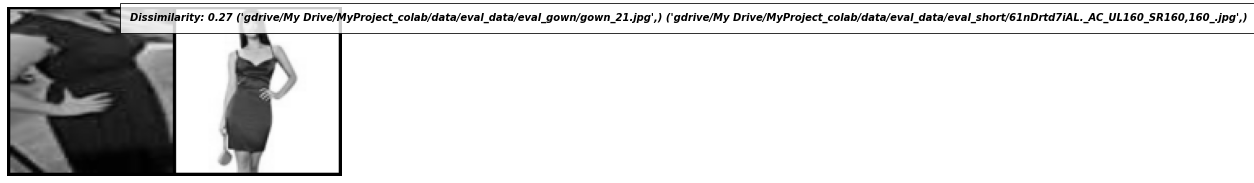

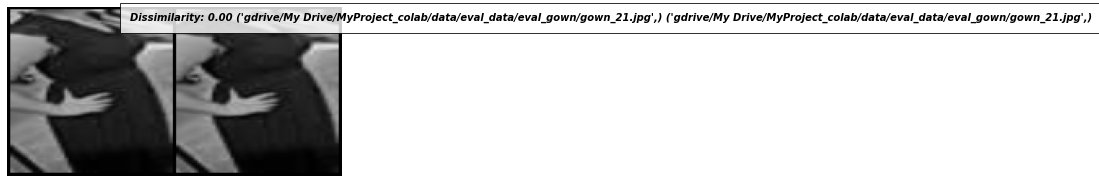

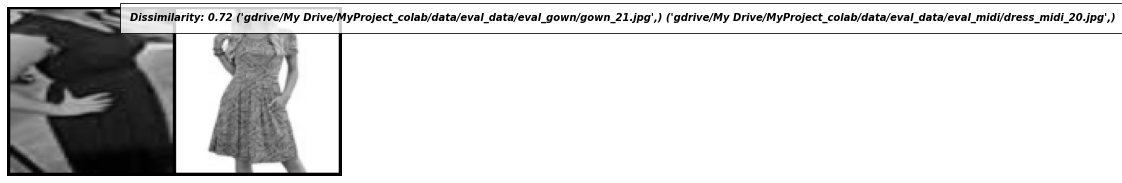

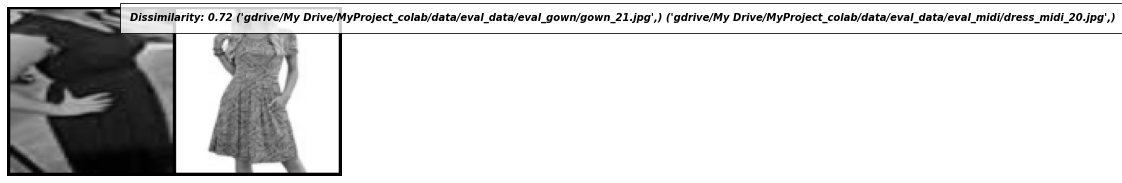

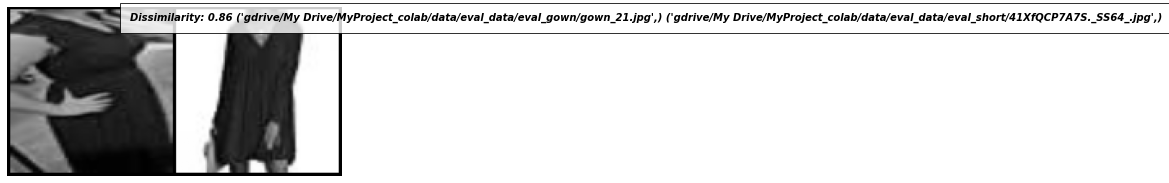

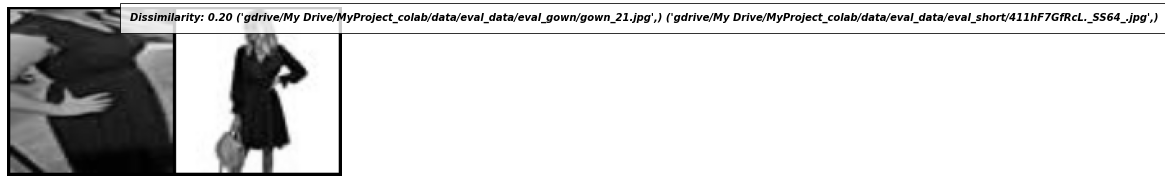

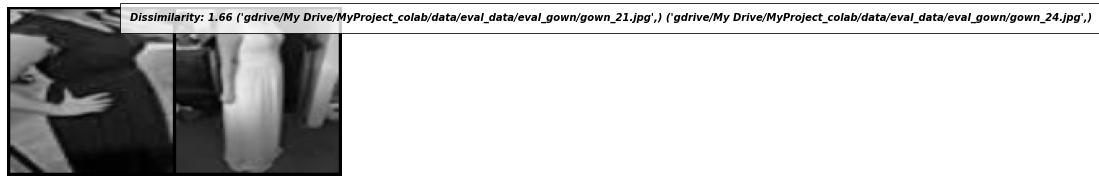

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.eval_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_,label0,_ = next(dataiter)

x0.size()

for i in range(10):
    _,x1,label2,_,label1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} {} {}'.format(euclidean_distance.item(), label0, label1))



In [ ]:
files_anchor = get_image_files(Config.anchor_folder)
files_test = get_image_files(Config.test_folder)
files_test[2]


Path('gdrive/My Drive/MyProject_colab/data/test/gown_4.jpg')

In [ ]:
mylist = []

for i in range(len(files_test)):
   
    #print(label_func(files_test[i]))
    for k in range(len(files_anchor)):        
          mytuple = (files_anchor[i],files_test[k-i])
          mylist.append(mytuple)
          break
    

In [ ]:
mylist

[(Path('gdrive/My Drive/MyProject_colab/data/original/gown_1.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_2.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown_2.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_8.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown3.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_7.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown_4.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_6.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown_5.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_5.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown_6.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_1.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown_7.jpg'),
  Path('gdrive/My Drive/MyProject_colab/data/test/gown_4.jpg')),
 (Path('gdrive/My Drive/MyProject_colab/data/original/gown_8.jpg'),
  

In [ ]:

def euclidean_distance_image(fn0,fn1):
    "Open and load a `PIL.Image` and convert to `Tensor` and calculate euclidean distance"
    
    
    img0Test = Image.open(fn0)
    img1Test = Image.open(fn1)

    img0Test = img0Test.convert("L")
    img1Test = img1Test.convert("L")
    

    transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
    img0Test = transform(img0Test)

    img1Test = transform(img1Test)
   
     
    
    
    x0b = img0Test.unsqueeze(0)
 
    x1b = img1Test.unsqueeze(0)
    #print(x1b.size())
    concatenated = torch.cat((x0b,x1b),0)
    #print(x0b.shape)
    output1,output2 = net(Variable(x0b).cuda(),Variable(x1b).cuda())
    #print(output1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    
    
    
    print('{:.2f}'.format(euclidean_distance.item()), fn0, fn1)
    return '{:.2f}'.format(euclidean_distance.item()), fn0, fn1
    


Example 1


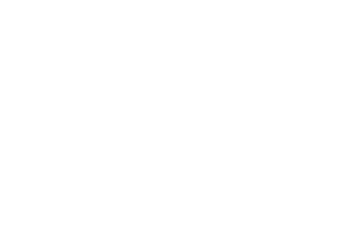

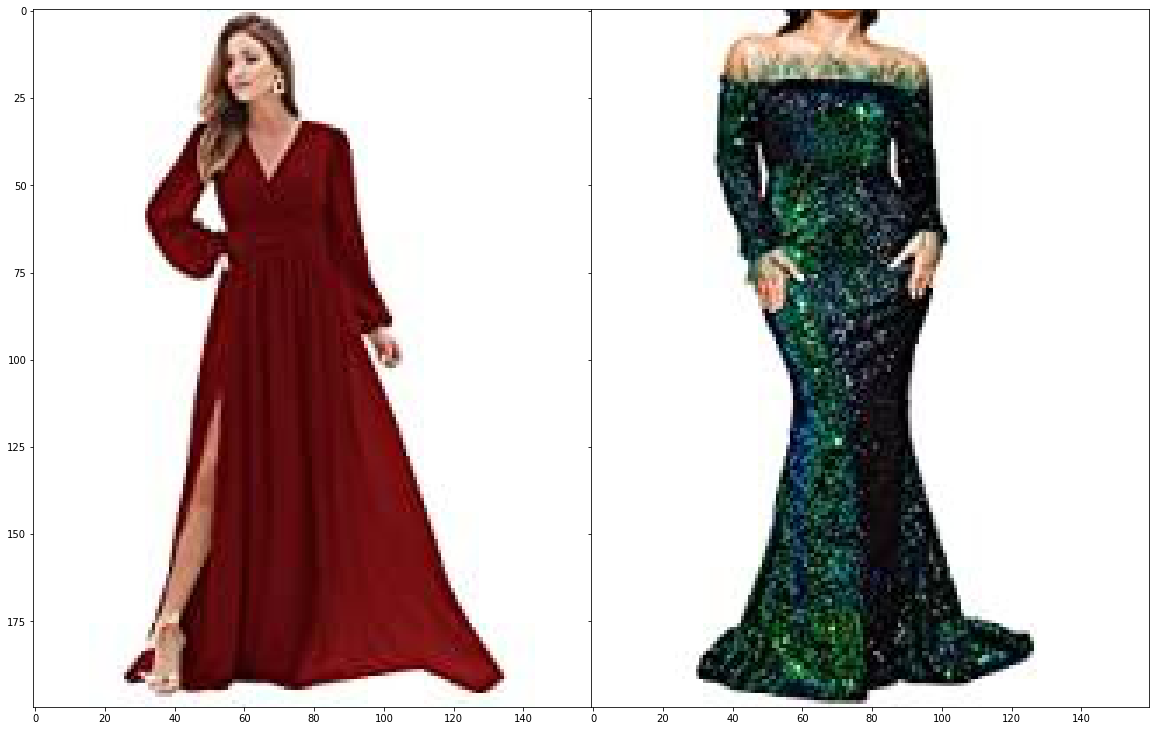

0.79 gdrive/My Drive/MyProject_colab/data/original/gown_1.jpg gdrive/My Drive/MyProject_colab/data/test/gown_2.jpg
Example 2


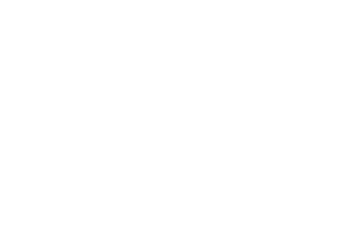

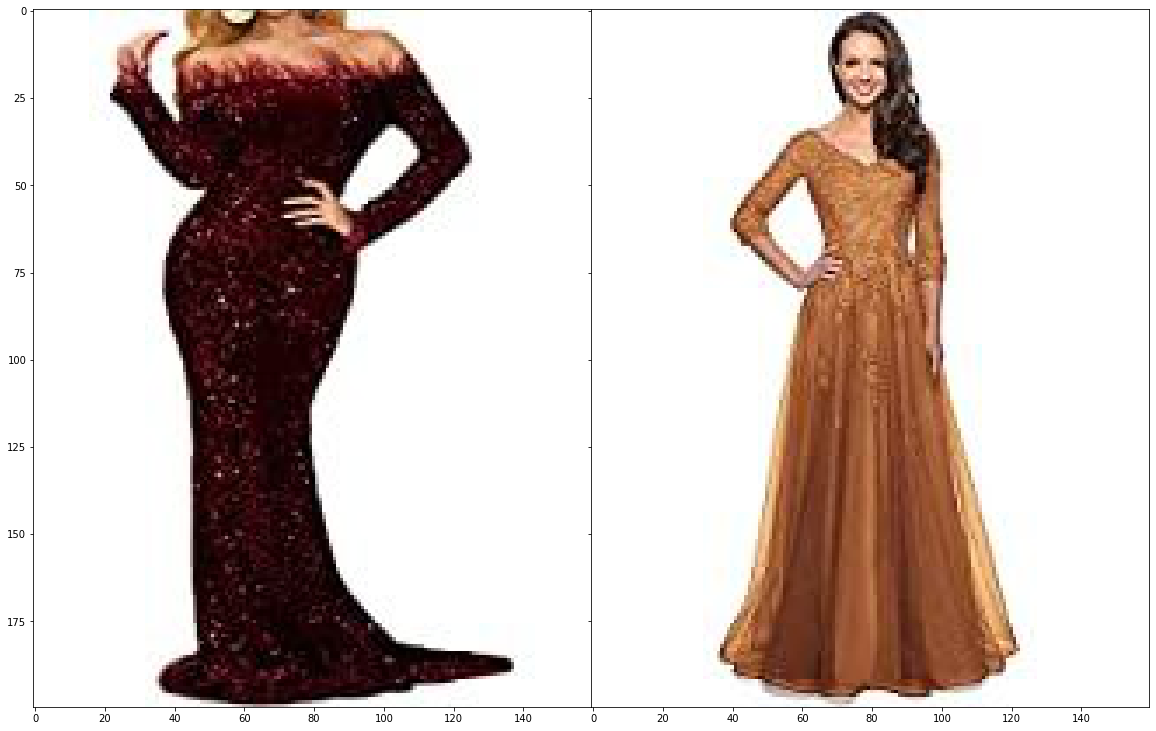

0.87 gdrive/My Drive/MyProject_colab/data/original/gown_2.jpg gdrive/My Drive/MyProject_colab/data/test/gown_8.jpg
Example 3


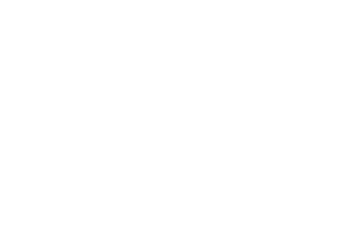

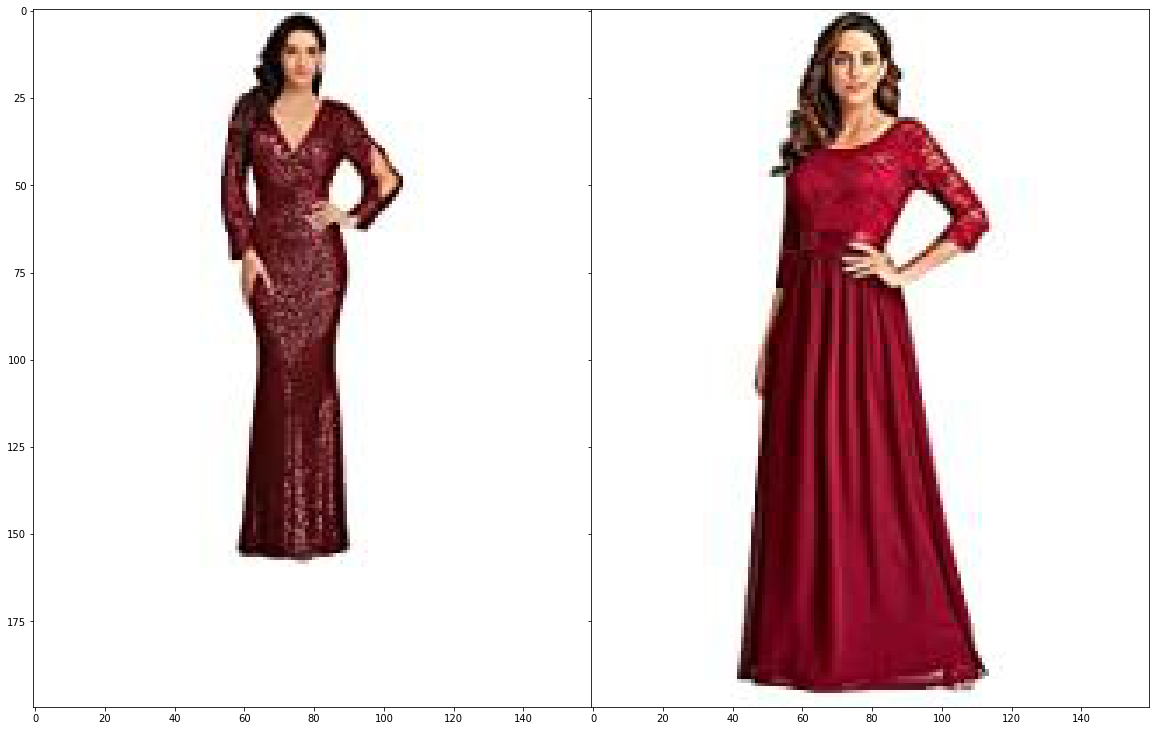

0.61 gdrive/My Drive/MyProject_colab/data/original/gown3.jpg gdrive/My Drive/MyProject_colab/data/test/gown_7.jpg
Example 4


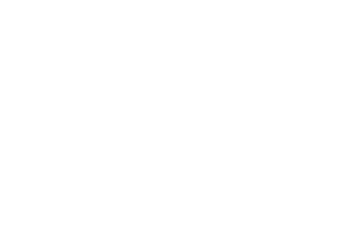

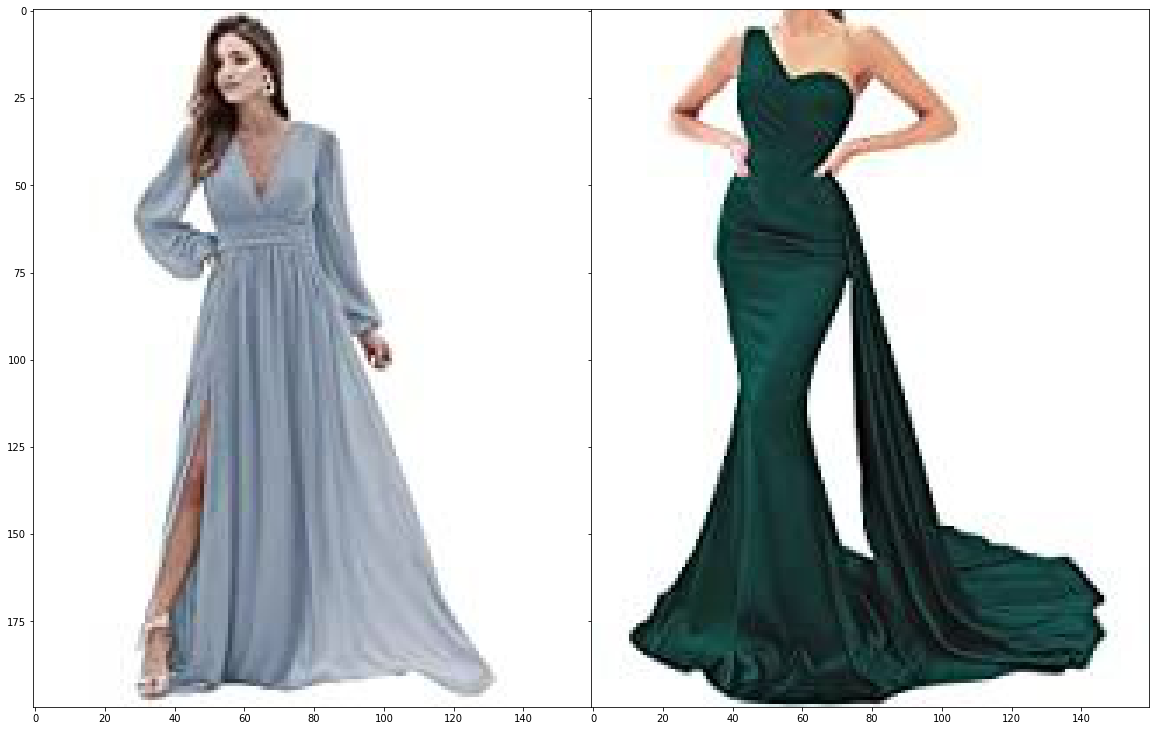

0.26 gdrive/My Drive/MyProject_colab/data/original/gown_4.jpg gdrive/My Drive/MyProject_colab/data/test/gown_6.jpg
Example 5


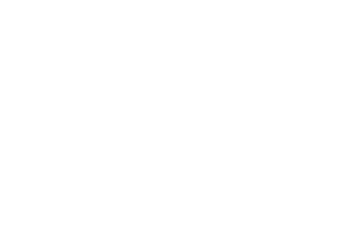

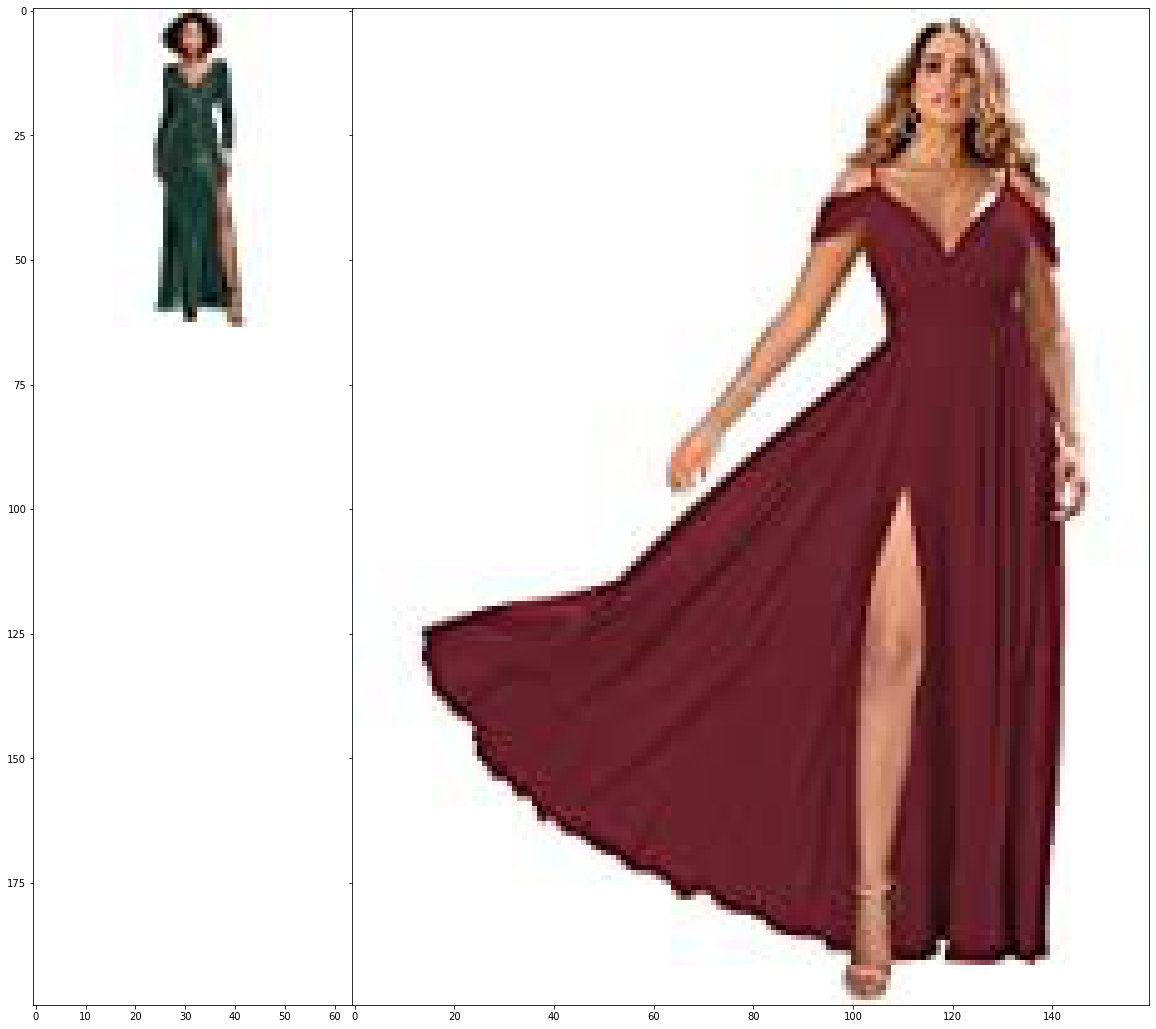

0.81 gdrive/My Drive/MyProject_colab/data/original/gown_5.jpg gdrive/My Drive/MyProject_colab/data/test/gown_5.jpg
Example 6


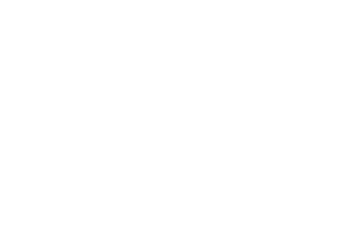

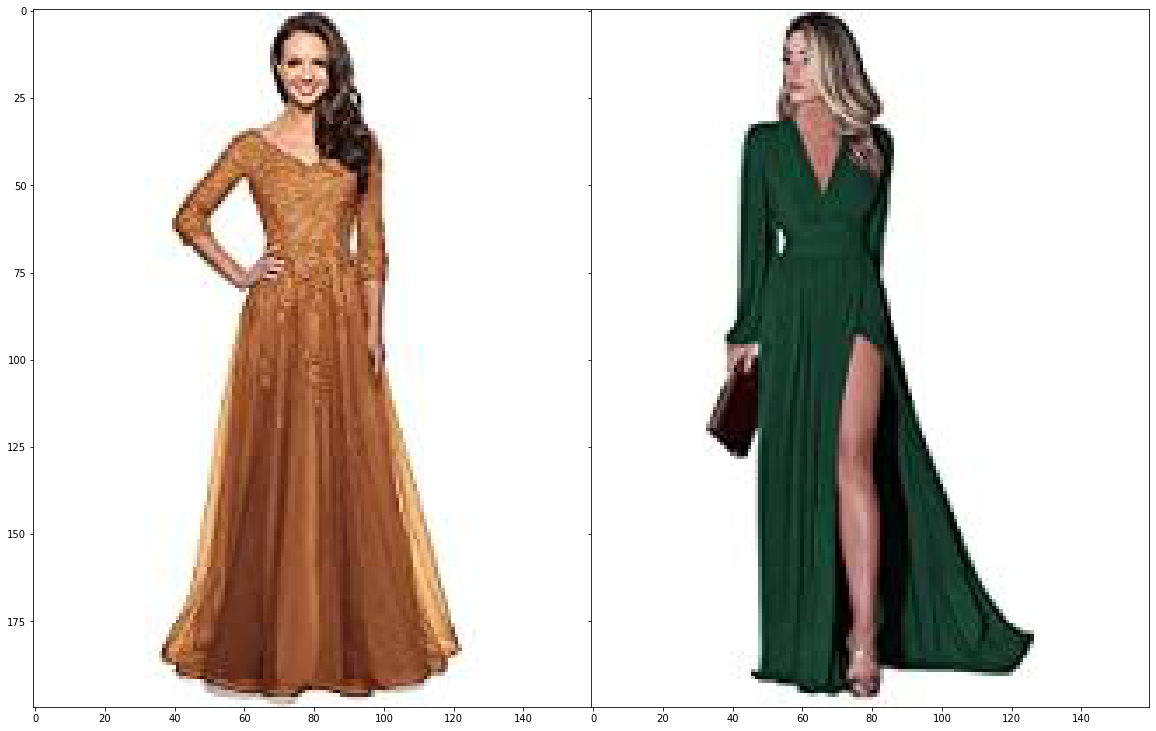

0.93 gdrive/My Drive/MyProject_colab/data/original/gown_6.jpg gdrive/My Drive/MyProject_colab/data/test/gown_1.jpg
Example 7


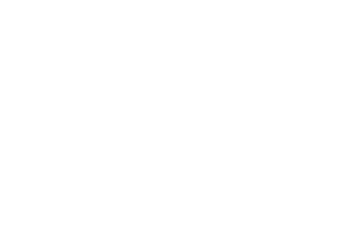

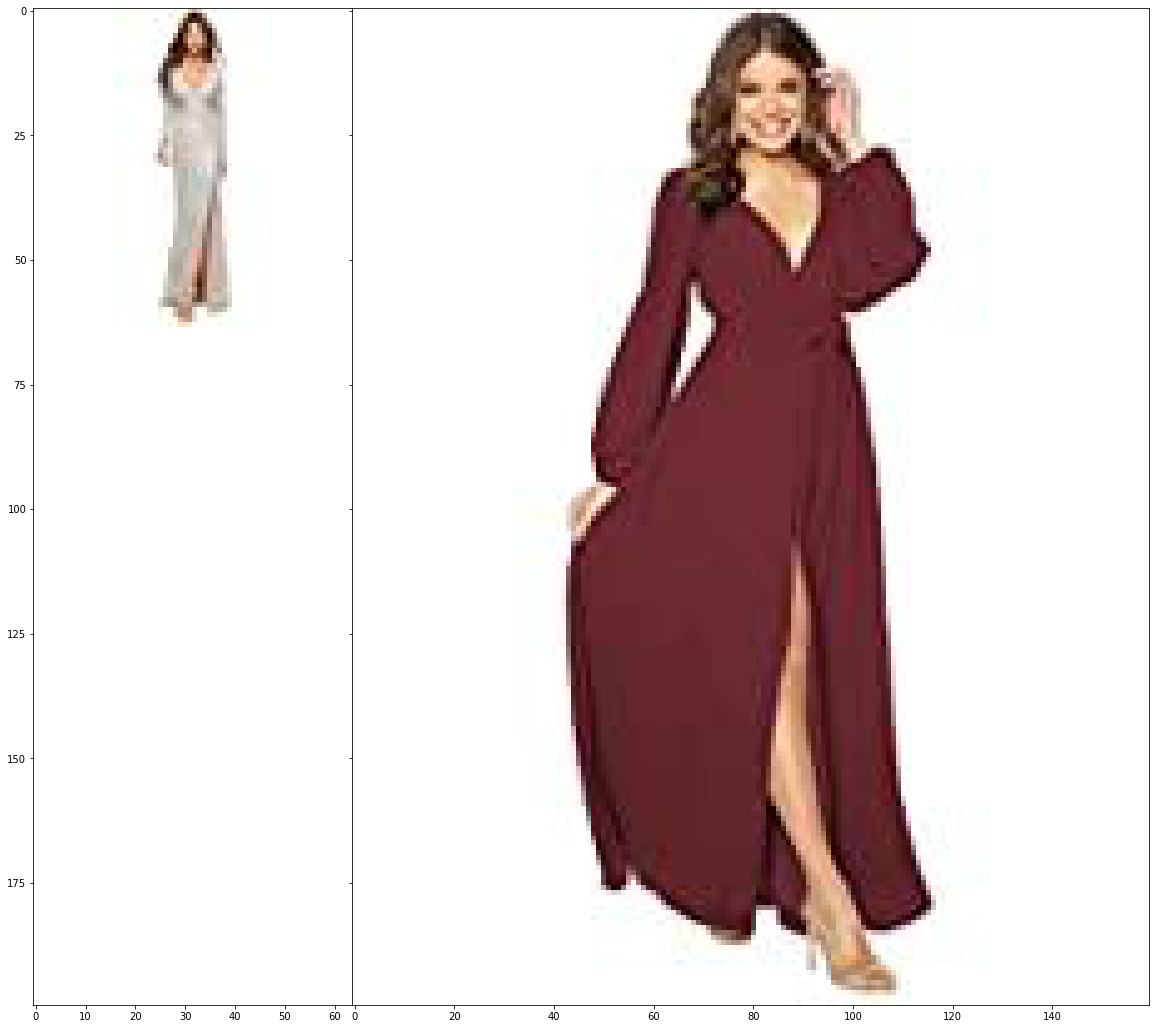

0.70 gdrive/My Drive/MyProject_colab/data/original/gown_7.jpg gdrive/My Drive/MyProject_colab/data/test/gown_4.jpg
Example 8


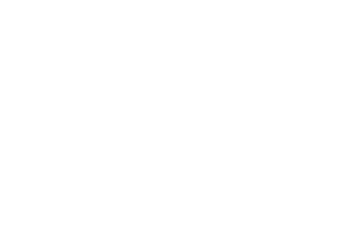

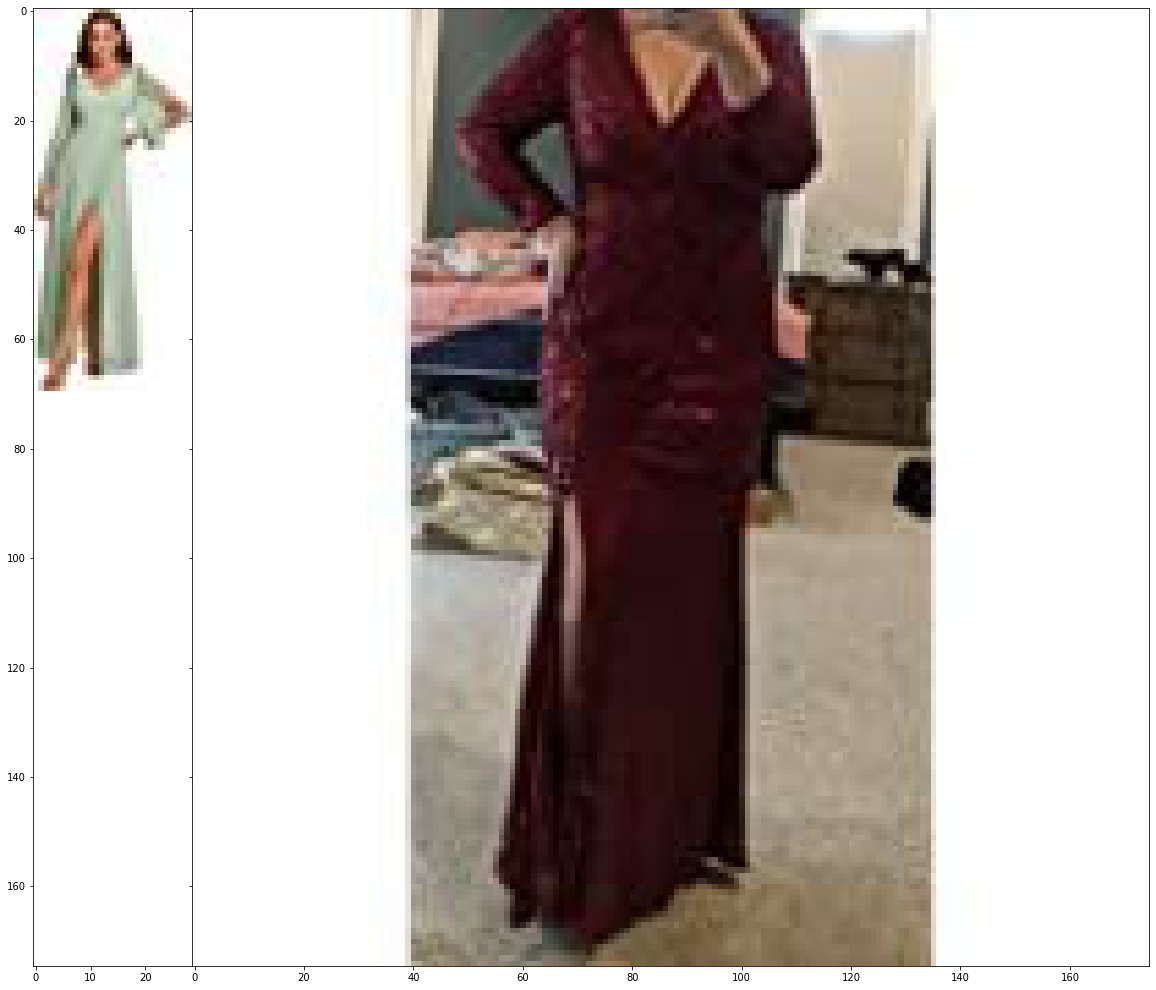

0.83 gdrive/My Drive/MyProject_colab/data/original/gown_8.jpg gdrive/My Drive/MyProject_colab/data/test/gown3.jpg


In [ ]:
i=0
for index, mytuple in enumerate(mylist):
    element_one = mytuple[0]
    element_two = mytuple[1]
    i=i+1
    print("Example " + str(i))  
    rgb_display(mytuple[0], mytuple[1])
    euclidean_distance_image(element_one, element_two)